<a href="https://colab.research.google.com/github/weiling0325/Schizophrenia-Detection-Using-Microbiome-Data/blob/main/Approach_1_pyCausalFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyCausalFS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.9/300.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
from pyCausalFS import SSD

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
import pickle

# import warning library to suppress warnings
from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None)

In [4]:
train_df = pd.read_csv('/content/drive/MyDrive/Dataset/training_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/testing_data.csv')

In [5]:
X_train = train_df
y_train = train_df['diagnosis']

X_test = test_df.drop(columns=['diagnosis'])
y_test = test_df['diagnosis']

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
# Custom Wrapper for GSMB
class GSMBSelector(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.05, target_variable_index=0, is_discrete=0):
        self.alpha = alpha
        self.target_variable_index = target_variable_index
        self.is_discrete = is_discrete
        self.mb_result = None

    def fit(self, X, y=None):
        # Convert X to a NumPy array if it is not already
        data_array = X if isinstance(X, np.ndarray) else X.values
        # Apply GSMB to select the Markov Blanket
        self.mb_result, _ = GSMB(data_array, self.target_variable_index, self.alpha, self.is_discrete)
        return self

    def transform(self, X):
        # Select only the columns corresponding to the Markov Blanket
        return X[:, self.mb_result] if isinstance(X, np.ndarray) else X.iloc[:, self.mb_result]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def score(self, X, y):
        # Use a simple classifier to evaluate the performance of the selected features
        X_selected = self.transform(X)
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_selected, y)
        y_pred = clf.predict(X_selected)
        return accuracy_score(y, y_pred)

In [ ]:
from pyCausalFS.CBD.MBs.GSMB import GSMB

# Initialize the GSMB selector
gsmbe = GSMBSelector(target_variable_index=0, is_discrete=0)

# Fit the GSMB selector to the training data
gsmbe.fit(X_train.values, y_train.values)

# Get the column names of the selected features
selected_features = X_train.columns[gsmbe.mb_result]

# Check if 'age' is among the selected features
if 'age' not in selected_features:
    # If 'age' is not selected, add it manually
    selected_features = selected_features.tolist()
    selected_features.append('age')

# Output the results
print("Number of selected features:", len(selected_features))
print("Selected features:", selected_features)
print("Markov Blanket of the target variable:", gsmbe.mb_result)

Number of selected features: 24
Selected features: ['d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Holdemanella', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae;g__Solobacterium', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Bifidobacteriales;f__Bifidobacteriaceae;g__Bifidobacterium', 'd__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Corynebacteriales;f__Corynebacteriaceae;__', 'd__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Leuconostocaceae;g__Weissella', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridia;f__Hungateiclostridiaceae;__', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridia;f__Hungateiclostridiaceae;g__Ruminiclostridium', 'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnospiraceae;__', 'd__Bacteria;p__Firmicutes;c__Clostridia;o__Lachnospirales;f__Lachnosp

In [ ]:
from sklearn.model_selection import cross_val_score

# Create a new DataFrame with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the RandomForestClassifier using the selected features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_selected, y_train)

# Make predictions on the test set with the selected features
y_pred = rf.predict(X_test_selected)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with selected features: {accuracy}")

# Evaluate the model using cross-validation with different scoring metrics
accuracy_scores = cross_val_score(rf, X_train_selected, y_train, cv=5, scoring='accuracy')

# Display the results for each metric
print(f"Accuracy scores (5-fold CV): {accuracy_scores}")
print(f"Mean accuracy: {accuracy_scores.mean():.4f}")

Accuracy with selected features: 0.7755102040816326
Accuracy scores (5-fold CV): [0.69565217 0.73913043 0.77272727 0.68181818 0.72727273]
Mean accuracy: 0.7233


In [9]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.79      0.76      0.78        25

    accuracy                           0.78        49
   macro avg       0.78      0.78      0.78        49
weighted avg       0.78      0.78      0.78        49


Confusion Matrix:
[[19  5]
 [ 6 19]]



AUC-ROC Score: 0.8525


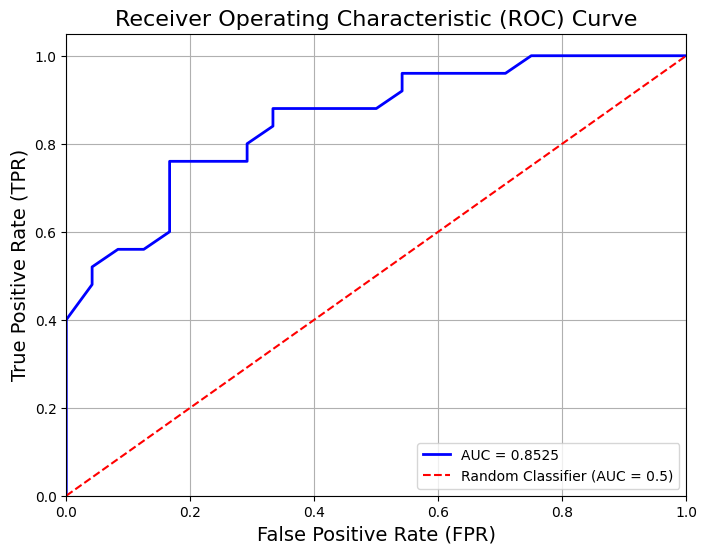

In [11]:
# Calculate Probabilities for the positive class
y_pred_prob = rf.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Hyperparameter Tuning for RandomForestClassifier
# Define the parameter distribution for RandomForestClassifier
rf_param_dist = {
    'n_estimators': [100, 200, 300],    # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],    # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],    # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],      # Minimum samples in each leaf node
    'bootstrap': [True, False]          # Whether to use bootstrap samples when building trees
}

# Perform hyperparameter tuning for RandomForest using RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)

# Fit the Random Forest RandomizedSearchCV object to the selected feature subset
rf_random_search.fit(X_train_selected, y_train)

# Get the best Random Forest hyperparameters
best_rf_params = rf_random_search.best_params_
print(f"Best Random Forest parameters: {best_rf_params}")

# Get the best Random Forest model
best_rf_model = rf_random_search.best_estimator_

# Evaluate the best Random Forest model on the test set
y_pred = best_rf_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best Random Forest model on the test set: {test_accuracy}")

# Evaluate the best Random Forest using 5-fold Cross-Validation
accuracy_scores = cross_val_score(best_rf_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"Accuracy scores (5-fold CV): {accuracy_scores}")
print(f"Mean accuracy: {accuracy_scores.mean():.4f}")


Best Random Forest parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': True}
Accuracy of the best Random Forest model on the test set: 0.7551020408163265
Accuracy scores (5-fold CV): [0.65217391 0.73913043 0.90909091 0.77272727 0.77272727]
Mean accuracy: 0.7692


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        24
           1       0.76      0.76      0.76        25

    accuracy                           0.76        49
   macro avg       0.76      0.76      0.76        49
weighted avg       0.76      0.76      0.76        49


Confusion Matrix:
[[18  6]
 [ 6 19]]



AUC-ROC Score: 0.8333


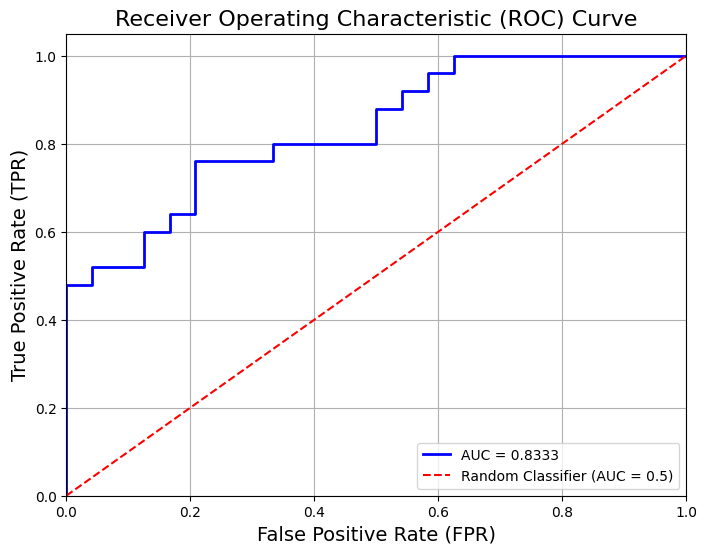

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_rf_model.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
###LogisticRegression
from sklearn.linear_model import LogisticRegression

# Train the LogisticRegression using the selected features
clf = LogisticRegression(random_state=42)
clf.fit(X_train_selected, y_train)

# Make predictions on the test set with the selected features
y_pred = clf.predict(X_test_selected)

# Evaluate the model performance
clf_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of LogisticRegression with selected features: {clf_accuracy}")

# Evaluate the model using 5-fold Cross-validation
clf_accuracy_scores = cross_val_score(clf, X_train_selected, y_train, cv=5, scoring='accuracy')

# Display the results for each metric
print(f"Accuracy scores (5-fold CV): {clf_accuracy_scores}")
print(f"Mean accuracy: {clf_accuracy_scores.mean():.4f}")


Accuracy of LogisticRegression with selected features: 0.673469387755102
Accuracy scores (5-fold CV): [0.60869565 0.69565217 0.90909091 0.72727273 0.59090909]
Mean accuracy: 0.7063


In [ ]:
# Perform the hyperparameters tuning for LogisticRegression using RandomizedSearchCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define the parameter distribution for LogisticRegression
clf_param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization penalty
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['lbfgs', 'liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'max_iter': [100, 200, 300]  # Maximum number of iterations
}

# Perform hyperparameter tuning for LogisticRegression using RandomizedSearchCV
clf_random_search = RandomizedSearchCV(estimator=clf, param_distributions=clf_param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)

# Fit the LogisticRegression RandomizedSearchCV object to the selected feature subset
clf_random_search.fit(X_train_scaled, y_train)

# Get the best LogisticRegression hyperparameters
best_clf_params = clf_random_search.best_params_
print(f"Best LogisticRegression parameters: {best_clf_params}")

# Get the best LogisticRegression model
best_clf_model = clf_random_search.best_estimator_

# Evaluate the best LogisticRegression model on the test set
y_pred = best_clf_model.predict(X_test_scaled)
clf_test_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best LogisticRegression model on the test set: {clf_test_accuracy}")

# Accuracy scores with cross-validation
accuracy_scores = cross_val_score(best_clf_model, X_train_scaled, y_train, cv=5, scoring='accuracy')

# Display cross-validation results
print(f"Accuracy scores (5-fold CV): {accuracy_scores}")
print(f"Mean accuracy: {accuracy_scores.mean():.4f}")

Best LogisticRegression parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
Accuracy of the best LogisticRegression model on the test set: 0.7551020408163265
Accuracy scores (5-fold CV): [0.69565217 0.65217391 0.90909091 0.72727273 0.63636364]
Mean accuracy: 0.7241


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        24
           1       0.81      0.68      0.74        25

    accuracy                           0.76        49
   macro avg       0.76      0.76      0.75        49
weighted avg       0.76      0.76      0.75        49


Confusion Matrix:
[[20  4]
 [ 8 17]]



AUC-ROC Score: 0.6683


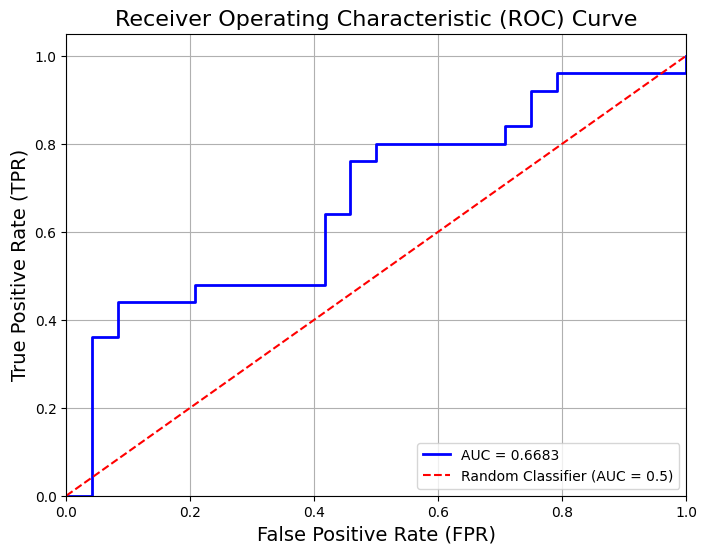

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_clf_model.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

**SMOTE Technique With RandomForestclassifier**

In [ ]:
# Define the pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the pipeline using the selected features
pipeline.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test_selected)
accuracy_before_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (before tuning): {accuracy_before_tuning:.4f}")

# Evaluate the model using cross-validation with different scoring metrics
cv_accuracy_before = cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (before tuning): {cv_accuracy_before}")
print(f"Mean CV Accuracy (before tuning): {cv_accuracy_before.mean():.4f}")

Test Accuracy (before tuning): 0.6735
5-Fold CV Accuracy (before tuning): [0.65217391 0.73913043 0.81818182 0.68181818 0.68181818]
Mean CV Accuracy (before tuning): 0.7146


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        24
           1       0.66      0.76      0.70        25

    accuracy                           0.67        49
   macro avg       0.68      0.67      0.67        49
weighted avg       0.68      0.67      0.67        49


Confusion Matrix:
[[14 10]
 [ 6 19]]



AUC-ROC Score: 0.8242


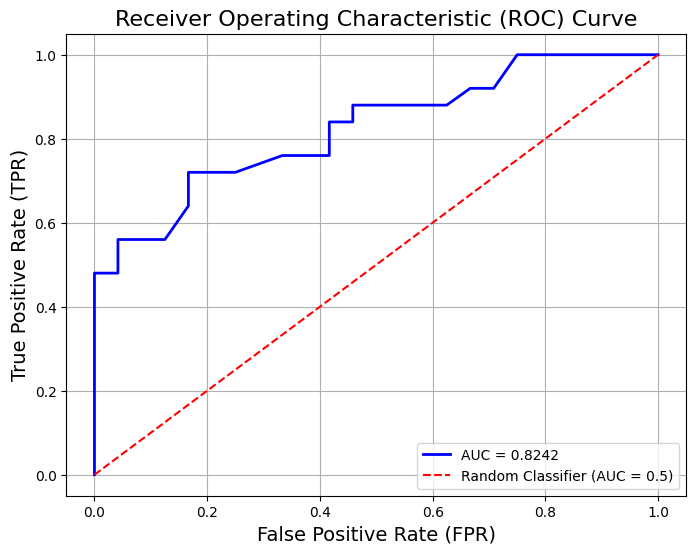

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for RandomForestclassifier using RandomizedSearchCV
rf_param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}
rf_random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=rf_param_dist, cv=5, n_iter=10, n_jobs=-1, random_state=42)
rf_random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_rf_params = rf_random_search.best_params_
print(f"Best Random Forest parameters: {best_rf_params}")

# Get the best Random Forest model
best_pipeline = rf_random_search.best_estimator_

# Evaluate the best Random Forest model on the test set
y_pred = best_pipeline.predict(X_test_selected)
accuracy_after_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (after tuning): {accuracy_after_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation after tuning
cv_accuracy_after = cross_val_score(best_pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (after tuning): {cv_accuracy_after}")
print(f"Mean CV Accuracy (after tuning): {cv_accuracy_after.mean():.4f}")

Best Random Forest parameters: {'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_depth': 10, 'rf__bootstrap': True}
Test Accuracy (after tuning): 0.7143
5-Fold CV Accuracy (after tuning): [0.65217391 0.73913043 0.86363636 0.72727273 0.72727273]
Mean CV Accuracy (after tuning): 0.7419


In [ ]:
# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        24
           1       0.70      0.76      0.73        25

    accuracy                           0.71        49
   macro avg       0.72      0.71      0.71        49
weighted avg       0.72      0.71      0.71        49


Confusion Matrix:
[[16  8]
 [ 6 19]]



AUC-ROC Score: 0.8317


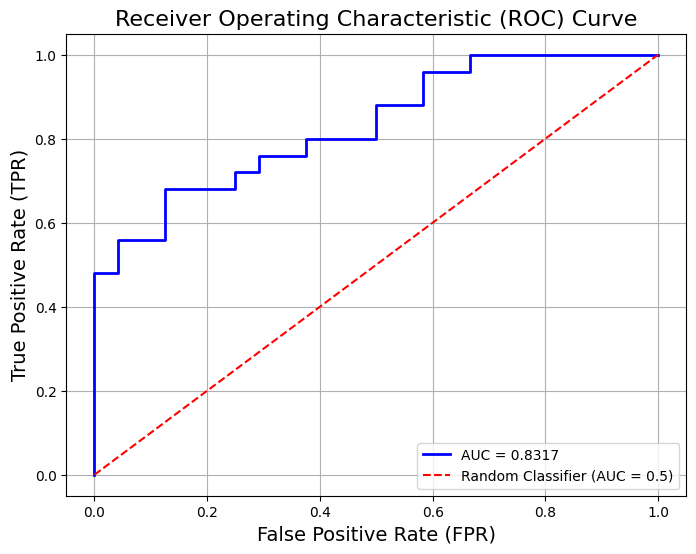

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

**SMOTE Technique With LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define the pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42))
])

# Train the pipeline using the selected features
pipeline.fit(X_train_selected, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test_selected)
accuracy_before_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (before tuning): {accuracy_before_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation
cv_accuracy_before = cross_val_score(pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (before tuning): {cv_accuracy_before}")
print(f"Mean CV Accuracy (before tuning): {cv_accuracy_before.mean():.4f}")


Test Accuracy (before tuning): 0.6735
5-Fold CV Accuracy (before tuning): [0.56521739 0.69565217 0.90909091 0.68181818 0.63636364]
Mean CV Accuracy (before tuning): 0.6976


In [ ]:
# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        24
           1       0.66      0.76      0.70        25

    accuracy                           0.67        49
   macro avg       0.68      0.67      0.67        49
weighted avg       0.68      0.67      0.67        49


Confusion Matrix:
[[14 10]
 [ 6 19]]



AUC-ROC Score: 0.7550


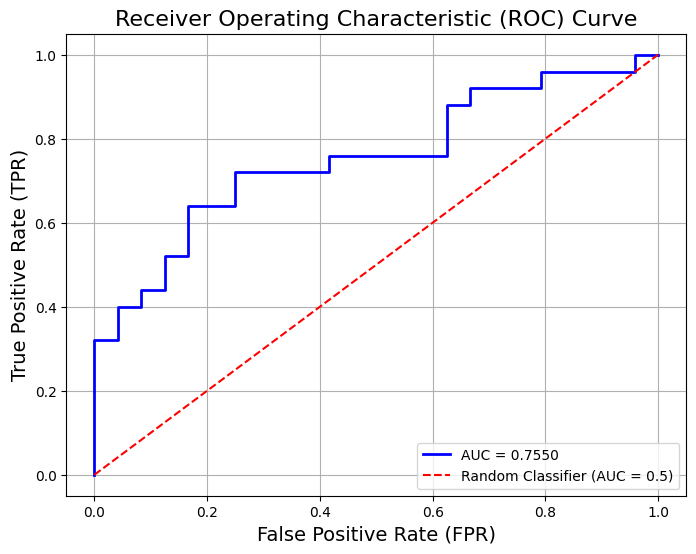

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

# Perform the hyperparameters tuning for LogisticRegression using RandomizedSearchCV
param_dist = {
    'clf__penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization penalty
    'clf__C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'clf__solver': ['lbfgs', 'liblinear', 'saga'],  # Algorithm to use in the optimization problem
    'clf__max_iter': [100, 200, 300]  # Maximum number of iterations
}
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=5, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_selected, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f'Best hyperparameters: {best_params}')

# Train the model with the best hyperparameters
best_pipeline = random_search.best_estimator_

# Evaluate the tuned model on the test set
y_pred = best_pipeline.predict(X_test_selected)
accuracy_after_tuning = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (after tuning): {accuracy_after_tuning:.4f}")

# Evaluate the model with 5-fold cross-validation after tuning
cv_accuracy_after = cross_val_score(best_pipeline, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"5-Fold CV Accuracy (after tuning): {cv_accuracy_after}")
print(f"Mean CV Accuracy (after tuning): {cv_accuracy_after.mean():.4f}")


Best hyperparameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__max_iter': 100, 'clf__C': 100}
Test Accuracy (after tuning): 0.6122
5-Fold CV Accuracy (after tuning): [0.65217391 0.73913043 0.86363636 0.63636364 0.72727273]
Mean CV Accuracy (after tuning): 0.7237


In [ ]:
# Generate a classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.54      0.58        24
           1       0.61      0.68      0.64        25

    accuracy                           0.61        49
   macro avg       0.61      0.61      0.61        49
weighted avg       0.61      0.61      0.61        49


Confusion Matrix:
[[13 11]
 [ 8 17]]



AUC-ROC Score: 0.6450


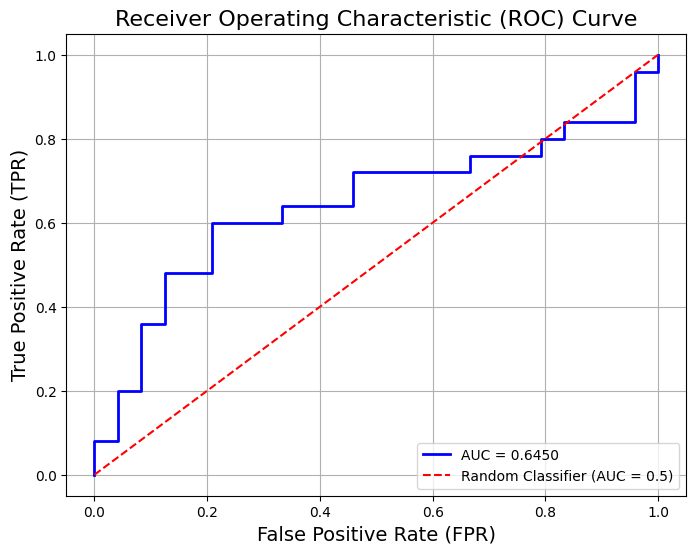

In [ ]:
# Calculate Probabilities for the positive class
y_pred_prob = best_pipeline.predict_proba(X_test_selected)[:, 1]

# Calculate the AUC-ROC score
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"\nAUC-ROC Score: {auc_score:.4f}")

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()